### Notebook Overview  

This Jupyter notebook is the deliverable for **Course 5 – "Regression Analysis"** in the *Google Advanced Data Analytics Professional Certificate* program. Its goals are to  

1. **Engineer and clean features** (handle outliers, derive ratio variables, and create interpretable flags like `professional_driver`).  
2. **Check model assumptions** for logistic regression, including target encoding, multicollinearity diagnostics, and correlation analysis.  
3. **Prepare model-ready data** by dropping redundant predictors, encoding categorical variables, and splitting into training and test sets.  
4. **Build and evaluate a baseline logistic regression model** to predict user churn, using balanced class weights to address class imbalance.  
5. **Compare results against Google's baseline** to understand different trade-offs between accuracy and recall for churn detection.  

**Deliverables:**  
- Cleaned dataset with engineered features (`professional_driver`, `device_binary`, `label_2`)  
- Correlation analysis identifying and dropping highly collinear predictors  
- Train/test split and logistic regression pipeline with scaling  
- Baseline model performance metrics (accuracy, precision, recall, F1, ROC AUC)  
- Comparative evaluation: my model achieves much higher churn recall (70% vs 9% in the exemplar) at the cost of lower accuracy (67% vs 82%).  
  This improvement comes from using `class_weight="balanced"` (rather than the exemplar’s default `None`), which corrects for class imbalance by giving churners more weight in the loss function.  
  While overall accuracy drops, this trade-off makes the model far more effective for the real business goal of detecting churn.
- Executive summary including details and key insights of this part of the analysis and its implications for the overall project. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, \
RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
# Next step: Build a binomial logistic regression model to predict user churn based on a variety of variables

In [3]:
# Load the cleaned csv with added features into a dataframe
waze_df = pd.read_csv('../data/waze_features_v1.csv')
waze_df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_drive,km_per_driving_day,drives_per_driving_day
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,11.632058,138.360267,11.894737
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,128.186173,1246.901868,9.727273
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,32.201567,382.393602,11.875000
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,22.839778,304.530374,13.333333
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,58.091206,219.455667,3.777778


In [4]:
waze_df.tail()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_drive,km_per_driving_day,drives_per_driving_day
14294,14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone,52.554489,170.029229,3.235294
14295,14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android,116.073577,203.128760,1.750000
14296,14996,retained,273,219,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone,14.145320,182.225002,12.882353
14297,14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone,33.764655,675.293092,20.000000
14298,14998,retained,73,58,353.419797,3383,13,51,6030.498773,3042.436423,14,13,iPhone,103.974117,463.884521,4.461538


In [5]:
# Drop the ID column; it's just a duplicate index, no predictive value
waze_df = waze_df.drop('ID', axis=1)

In [6]:
# Check the df structure
waze_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14299 entries, 0 to 14298
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14299 non-null  int64  
 2   drives                   14299 non-null  int64  
 3   total_sessions           14299 non-null  float64
 4   n_days_after_onboarding  14299 non-null  int64  
 5   total_navigations_fav1   14299 non-null  int64  
 6   total_navigations_fav2   14299 non-null  int64  
 7   driven_km_drives         14299 non-null  float64
 8   duration_minutes_drives  14299 non-null  float64
 9   activity_days            14299 non-null  int64  
 10  driving_days             14299 non-null  int64  
 11  device                   14299 non-null  object 
 12  km_per_drive             14197 non-null  float64
 13  km_per_driving_day       13316 non-null  float64
 14  drives_per_driving_day

In [7]:
# Look at the class balance for the target 'label'
# Important: if churn is rare, accuracy by itself won’t mean much
waze_df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [8]:
# Basic summary stats for the numeric features
# Good first pass to spot scale differences and potential outliers
waze_df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14197.000000,13316.000000,13316.000000
mean,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530,233.937962,624.901950,10.051412
std,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835,618.091431,1063.347472,20.279879
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,1.008775,3.022063,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,33.038159,159.198988,1.650000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,73.966235,297.621133,4.133333
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,181.307906,592.816412,9.574405
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15777.426560,15420.234110,395.000000


In [9]:
# Quantile breakdown (50th, 75th, 90th, 95th, 99th) for key usage features
# Counts of how many rows live above the 95th percentile
# Helps flag long-tailed distributions before we decide on transformations

tail_cols = ['sessions','drives','total_sessions','total_navigations_fav1',
             'total_navigations_fav2', 'driven_km_drives','duration_minutes_drives']

qs = [0.50, 0.75, 0.90, 0.95, 0.99]
summary = {}
for c in tail_cols:
    qvals = waze_df[c].quantile(qs).to_dict()
    thr95 = qvals[0.95]
    n_above = (waze_df[c] > thr95).sum()
    summary[c] = {**{f"q{int(q*100)}": v for q, v in zip(qs, waze_df[c].quantile(qs))},
                  "n_above_95": int(n_above),
                  "pct_above_95": round(100*n_above/len(waze_df), 2)}

pd.DataFrame(summary).T.sort_values("pct_above_95", ascending=False)

,q50,q75,q90,q95,q99,n_above_95,pct_above_95
total_sessions,158.718571,253.540450,370.203281,455.439492,643.593683,715.0,5.00
driven_km_drives,3496.545617,5299.972162,7427.965782,8898.716275,12283.036125,715.0,5.00
duration_minutes_drives,1479.394387,2466.928876,3753.169211,4668.180092,6974.610252,715.0,5.00
total_navigations_fav1,71.000000,178.000000,320.000000,422.000000,664.000000,714.0,4.99
drives,48.000000,93.000000,152.000000,200.000000,306.020000,713.0,4.99
sessions,56.000000,111.000000,184.200000,243.000000,373.000000,709.0,4.96
total_navigations_fav2,9.000000,43.000000,88.000000,124.000000,208.000000,701.0,4.90


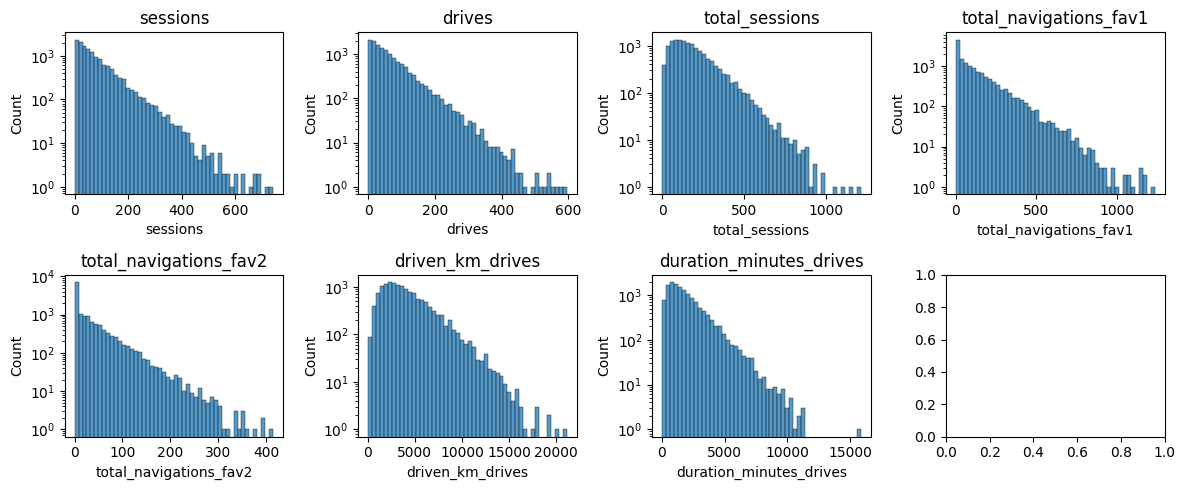

In [10]:
# Histograms of the same features to actually see the skew and tails
# Log scale on the y-axis makes rare but extreme values visible

tail_cols = ['sessions','drives','total_sessions','total_navigations_fav1',
             'total_navigations_fav2','driven_km_drives','duration_minutes_drives']

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()

for i, col in enumerate(tail_cols):
    sns.histplot(waze_df[col], bins=50, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

In [11]:
# All look normal except for duration_minutes_drives

In [12]:
# Filter rows where duration_minutes_drives is greater than 12k
extreme_duration = waze_df[waze_df['duration_minutes_drives'] > 12000]

# Count how many rows and unique users this affects
print("Rows above 12k minutes:", len(extreme_duration))
print("Unique users above 12k minutes:", extreme_duration.shape[0])

# Quick peek at the top of these rows
extreme_duration.sort_values('duration_minutes_drives', ascending=False).head()

Rows above 12k minutes: 1
Unique users above 12k minutes: 1


,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_drive,km_per_driving_day,drives_per_driving_day
2810,retained,21,17,82.855093,75,21,15,20108.36412,15851.72716,21,17,iPhone,1182.844948,1182.844948,1.0


In [13]:
# Cap the extreme outlier in 'duration_minutes_drives' at the 99th percentile
dur99 = waze_df['duration_minutes_drives'].quantile(0.99)
waze_df['duration_minutes_drives'] = np.where(
    waze_df['duration_minutes_drives'] > dur99, dur99, waze_df['duration_minutes_drives']
)

In [14]:
# Create professional_driver column for heavy, consistent users (60 drives+ AND active on 15+ different days)
waze_df['professional_driver'] = np.where((waze_df['drives'] >= 60) & (waze_df['driving_days'] >= 15), 1, 0)

# Check count of professionals and non-professionals 
print(waze_df['professional_driver'].value_counts()) 

# Check in-class churn rate 
waze_df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver
0    11811
1     2488
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

In [15]:
# Run a chi-square test to check if churn rates differ by driver status (pro vs non-pro).
# H0: Churn is independent of driver status (no association).
# H1: Churn is associated with driver status (there is a difference).

from scipy.stats import chi2_contingency

# Build contingency table: rows = professional_driver, cols = churn vs retained
contingency = pd.crosstab(waze_df['professional_driver'], waze_df['label'])

# Run chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square test statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

Chi-square test statistic: 213.072400958627
Degrees of freedom: 1
p-value: 2.934793856202841e-48


In [16]:
# Chi-square test returned a p-value of 2.9e-48, which is far below 0.05.
# We reject the H0: churn IS statistically associated with driver status

In [17]:
# Check for nulls; null values will impede our model
waze_df.isna().sum()

label                        0
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
km_per_drive               102
km_per_driving_day         983
drives_per_driving_day     983
professional_driver          0
dtype: int64

In [18]:
# Recompute the ratio features safely to avoid divide-by-zero NaNs.
# Earlier check showed every NaN aligns exactly with a zero denominator,
# so these aren’t missing values; they’re undefined because the denominator = 0.

waze_df['km_per_drive'] = waze_df['driven_km_drives'] / waze_df['drives'].replace(0, np.nan)
waze_df['km_per_drive'] = waze_df['km_per_drive'].fillna(0)

waze_df['km_per_driving_day'] = waze_df['driven_km_drives'] / waze_df['driving_days'].replace(0, np.nan)
waze_df['km_per_driving_day'] = waze_df['km_per_driving_day'].fillna(0)

waze_df['drives_per_driving_day'] = waze_df['drives'] / waze_df['driving_days'].replace(0, np.nan)
waze_df['drives_per_driving_day'] = waze_df['drives_per_driving_day'].fillna(0)

In [19]:
# Confirm no remaining NaNs in these columns
waze_df.isna().sum()

label                      0
sessions                   0
drives                     0
total_sessions             0
n_days_after_onboarding    0
total_navigations_fav1     0
total_navigations_fav2     0
driven_km_drives           0
duration_minutes_drives    0
activity_days              0
driving_days               0
device                     0
km_per_drive               0
km_per_driving_day         0
drives_per_driving_day     0
professional_driver        0
dtype: int64

In [20]:
# Create a binary-encoded version of the target in a new column 'label_2'
# retained = 0, churned = 1
waze_df['label_2'] = waze_df['label'].map({'retained': 0, 'churned': 1})

# Quick check of the new binary target
waze_df[['label', 'label_2']].value_counts()

label     label_2
retained  0          11763
churned   1           2536
Name: count, dtype: int64

In [21]:
# Create a binary-encoded version of 'device' in a new column 'device_binary':
# - Android = 0, iPhone  = 1
waze_df['device_2'] = waze_df['device'].map({'Android': 0, 'iPhone': 1})

# Quick check of the new binary column
waze_df['device_2'].value_counts()

device_2
1    9225
0    5074
Name: count, dtype: int64

In [22]:
# First pass check for multicollinearity among numeric features.
# Use a Pearson correlation matrix to flag pairs of predictors that might overlap too much
# and cause instability in logistic regression coefficients.

waze_df.corr(method='pearson', numeric_only=True)

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day,professional_driver,label_2,device_2
sessions,1.000000,0.996843,0.590265,0.006441,0.005252,0.005220,0.003815,-0.003476,0.024594,0.020228,-0.281946,-0.008961,0.454885,0.401584,0.038045,0.014466
drives,0.996843,1.000000,0.588118,0.006001,0.004551,0.006896,0.003708,-0.002958,0.024324,0.019975,-0.285718,-0.008772,0.456263,0.403413,0.038548,0.013851
total_sessions,0.590265,0.588118,1.000000,0.006180,-0.000047,0.007659,0.001690,-0.000376,0.012932,0.009798,-0.177003,-0.015169,0.263337,0.234289,0.025046,0.013054
n_days_after_onboarding,0.006441,0.006001,0.006180,1.000000,-0.004536,-0.006433,-0.005056,-0.010535,-0.009418,-0.007321,0.004090,0.011764,-0.000851,0.003770,-0.129263,-0.011299
total_navigations_fav1,0.005252,0.004551,-0.000047,-0.004536,1.000000,0.003734,-0.006262,0.006287,0.010318,0.010024,-0.004403,-0.000171,0.011343,0.001257,0.055537,-0.000679
total_navigations_fav2,0.005220,0.006896,0.007659,-0.006433,0.003734,1.000000,0.000159,-0.004371,-0.004836,0.000938,0.007310,0.008992,0.003338,0.003535,0.020051,0.001079
driven_km_drives,0.003815,0.003708,0.001690,-0.005056,-0.006262,0.000159,1.000000,0.693552,-0.004196,-0.007099,0.239580,0.355674,0.013780,-0.002012,0.019050,-0.002309
duration_minutes_drives,-0.003476,-0.002958,-0.000376,-0.010535,0.006287,-0.004371,0.693552,1.000000,-0.006002,-0.008172,0.175869,0.245397,0.002956,-0.010253,0.037799,-0.005352
activity_days,0.024594,0.024324,0.012932,-0.009418,0.010318,-0.004836,-0.004196,-0.006002,1.000000,0.947687,-0.005193,-0.397433,-0.320819,0.453825,-0.303851,-0.010221
driving_days,0.020228,0.019975,0.009798,-0.007321,0.010024,0.000938,-0.007099,-0.008172,0.947687,1.000000,-0.004005,-0.407917,-0.330804,0.469776,-0.294259,-0.003859


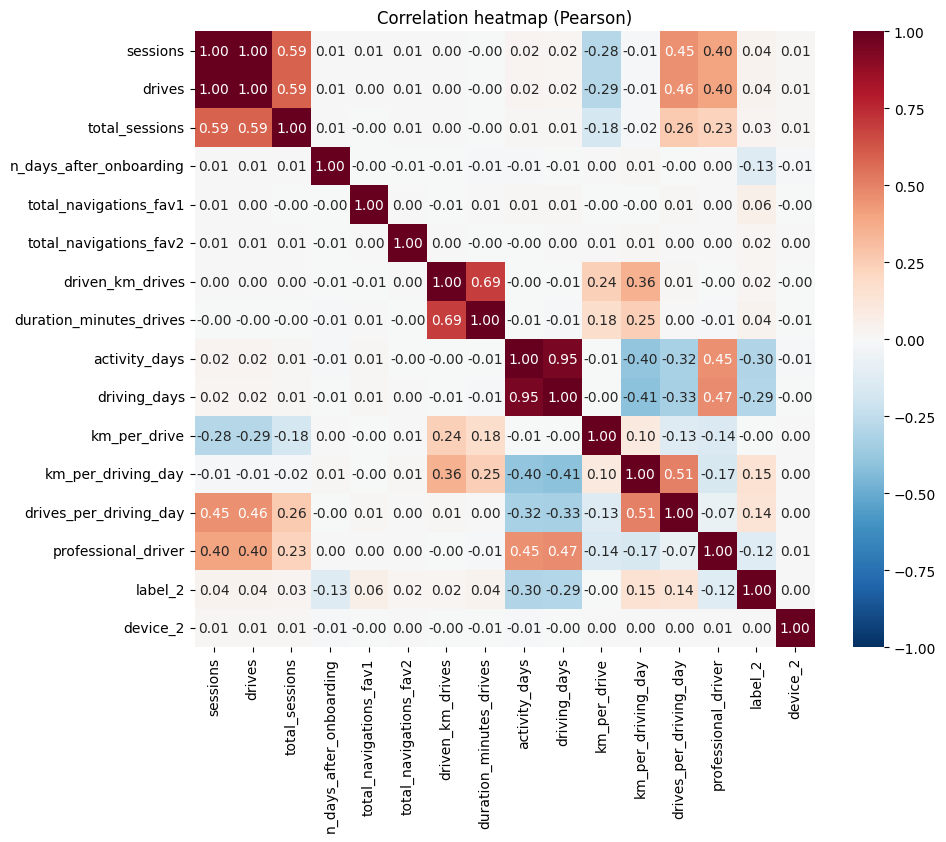

In [23]:
# Visualize the correlation matrix as a heatmap.
# Easier to spot strong positive/negative relationships at a glance compared to scanning the raw table.

corr = waze_df.corr(method='pearson', numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    center=0
)
plt.title("Correlation heatmap (Pearson)")
plt.show()

In [24]:
# Correlation results flagged two very strong overlaps:
# - sessions and drives (corr = 1.0)
# - driving_days and activity_days (corr ≈ 0.95)

# These pairs are essentially duplicates and will cause multicollinearity issues,
# so we’ll need to drop one variable from each pair before modeling.

In [25]:
# Isolate predictor variables (X) and target (y).
# Drop the original string label and keep the binary-encoded version for modeling.
# Also drop one variable from each multicollinear pair:

# We drop 'sessions' (keep 'drives') and 'driving_days' (keep 'activity_days').
# The features we kept showed slightly stronger correlation with churn,
# so they may carry more predictive signal.

In [26]:
# Define target
y = waze_df['label_2']

# Define predictors
X = waze_df.drop(columns=[
    'label',        # string target, not for modeling
    'label_2',      # binary target, moved to y
    'device',       # original string version of 'device_binary'
    'sessions',     # dropped due to perfect corr with drives
    'driving_days'  # dropped due to high corr with activity days
])

In [27]:
# Check for all numeric dtypes for the model
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14299 entries, 0 to 14298
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   drives                   14299 non-null  int64  
 1   total_sessions           14299 non-null  float64
 2   n_days_after_onboarding  14299 non-null  int64  
 3   total_navigations_fav1   14299 non-null  int64  
 4   total_navigations_fav2   14299 non-null  int64  
 5   driven_km_drives         14299 non-null  float64
 6   duration_minutes_drives  14299 non-null  float64
 7   activity_days            14299 non-null  int64  
 8   km_per_drive             14299 non-null  float64
 9   km_per_driving_day       14299 non-null  float64
 10  drives_per_driving_day   14299 non-null  float64
 11  professional_driver      14299 non-null  int64  
 12  device_2                 14299 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 1.4 MB


In [28]:
# Split data into train/test sets.
# Use stratify=y to preserve class balance in both splits.
# Set random_state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [29]:
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_drive,km_per_driving_day,drives_per_driving_day,professional_driver,device_2
147,108,186.192746,3116,243,126,9184.587914,5580.123677,24,85.042481,612.305861,7.200000,1,1
11335,2,3.487590,794,114,18,3286.545691,1780.902733,5,1643.272845,3286.545691,2.000000,0,1
10416,139,347.106403,331,4,7,7400.838975,2349.305267,15,53.243446,616.736581,11.583333,0,0
646,108,481.048448,2320,11,4,6566.424830,4558.459870,18,60.800230,410.401552,6.750000,1,1
8002,10,89.475821,2478,135,0,1271.248661,938.711572,27,127.124866,74.779333,0.588235,0,1


In [30]:
# Build a baseline logistic regression model.
# Logistic regression works best when numeric features are standardized,
# so we’ll scale the numeric predictors and leave binary flags as-is.
# Wrap everything in a pipeline to keep preprocessing + model together.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Separate numeric vs binary/categorical features
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
# Remove the already-binary flags from scaling
numeric_features = [col for col in numeric_features if col not in ['device_2','professional_driver']]

binary_features = ['device_2','professional_driver']

# Preprocess: scale numeric features, pass through binary features unchanged
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features)
    ]
)

# Logistic regression with balanced class weights (to handle churn imbalance)
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Final pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

# Fit the model
clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
# Evaluate the baseline model on the test set.
# Look beyond accuracy: churn is ~18%, so precision/recall/F1 and ROC–AUC/PR–AUC matter more.

# Predictions and churn probabilities
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # P(churn)

# Core metrics (positive class = churn = 1)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 score:  {f1:.3f}")
print(f"ROC AUC:   {roc:.3f}")

# Full breakdown per class (0=retained, 1=churned)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=['retained (0)', 'churned (1)']))

Accuracy:  0.670
Precision: 0.309
Recall:    0.696
F1 score:  0.428
ROC AUC:   0.740

Classification report:

              precision    recall  f1-score   support

retained (0)       0.91      0.66      0.77      2941
 churned (1)       0.31      0.70      0.43       634

    accuracy                           0.67      3575
   macro avg       0.61      0.68      0.60      3575
weighted avg       0.80      0.67      0.71      3575



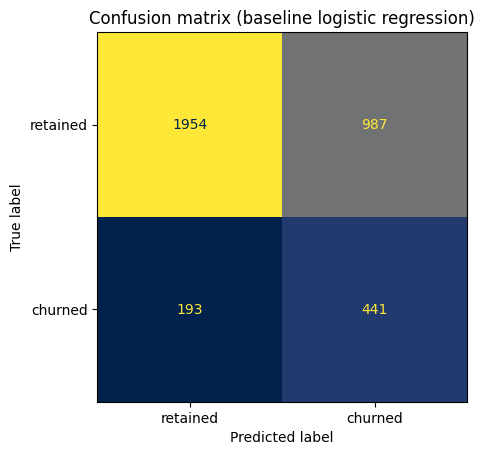

In [33]:
# Confusion matrix — quick visual on false positives/false negatives
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['retained', 'churned'],
                                      cmap='cividis', colorbar=False)
plt.title("Confusion matrix (baseline logistic regression)")
plt.show()

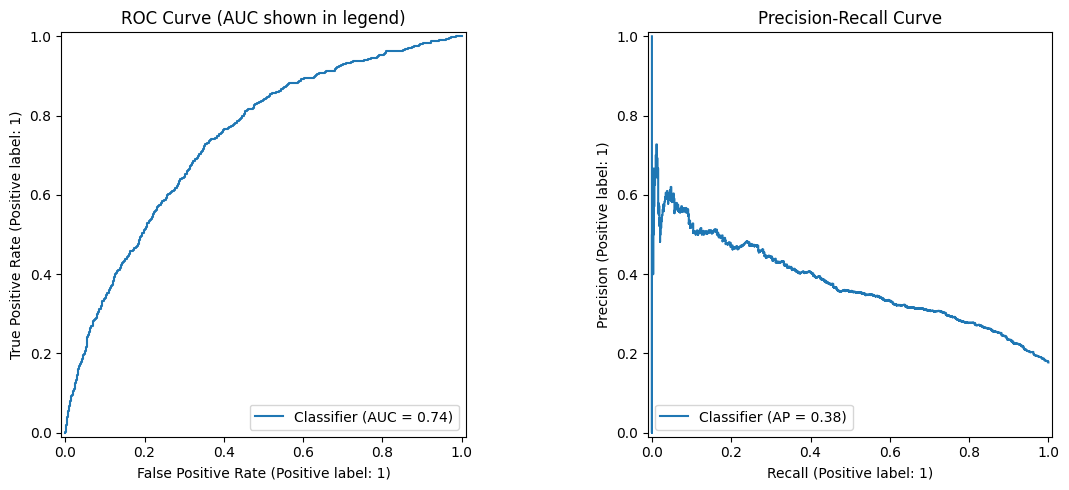

In [34]:
# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC curve — overall ranking quality

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0])
axes[0].set_title("ROC Curve (AUC shown in legend)")

# Precision–Recall curve — more informative with class imbalance
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

In [35]:
# ROC curve: AUC = 0.74 -> the model is meaningfully separating churners from retained users.
# Not perfect, but much better than random guessing (0.5 baseline).

# Precision–Recall curve: AP (Average Precision) = 0.38 -> reflects the challenge of class imbalance.
# The model finds most churners (good recall), but precision is modest.

In [36]:
# Baseline reference: what if we always predicted 'retained'?
# (Helps stakeholders see why accuracy alone is misleading.)
baseline_acc = (y_test == 0).mean()
print(f"Naive baseline accuracy (always predict retained): {baseline_acc:.3f}")

Naive baseline accuracy (always predict retained): 0.823


In [37]:
# Inspect which features the logistic regression model considers most important.
# Because numeric features were standardized with StandardScaler,
#   coefficients are on the same scale and can be compared directly across variables.
# Positive coefficients -> higher churn risk, negative coefficients -> more likely retained.

In [38]:
# Pair each feature name with its corresponding coefficient
feature_importance = list(zip(X_train.columns, log_reg.coef_[0]))

# Sort features by coefficient size (largest positive at the top)
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

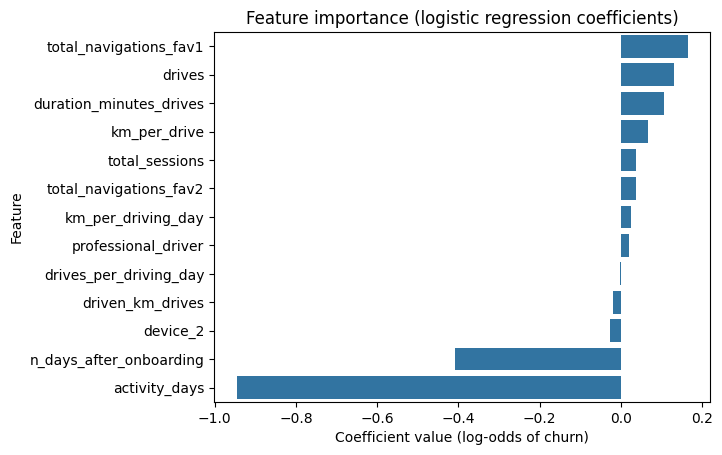

In [39]:
# Horizontal barplot of feature importances for easy comparison
sns.barplot(
    x=[coef for _, coef in feature_importance],
    y=[feat for feat, _ in feature_importance],
    orient='h'
)
plt.title("Feature importance (logistic regression coefficients)")
plt.xlabel("Coefficient value (log-odds of churn)")
plt.ylabel("Feature")
plt.show()

In [40]:
# Key Insights:
# Baseline logistic regression catches most churners (70% recall) but at the cost of many false alarms (31% precision).
# Accuracy looks low (0.67) because the model is willing to over-predict churn to capture more of them.
# ROC AUC of 0.74 shows the model is learning meaningful signal beyond random guessing.
# Overall: a decent baseline, but there’s room to tune the threshold or explore richer models.

In [41]:
# Since we cleaned the data further and added more features, let's save as a new csv
waze_df.to_csv('../data/waze_features_v2.csv', index=False)

### Executive Summary
[Executive Summary - Milestone 5](../reports/executive_summary_milestone_5.pdf)